In [72]:
# import the required packages
import numpy as np
import pandas as pd

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.tree import export_graphviz 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Packages imported!')

Solving environment: ...working... done

# All requested packages already installed.

Packages imported!


## 1. HR Analytics

1. [Load and Explore the Data](#load)
2. [Cleanse and Transform the Data](#clean)
3. [Correlation Analysis](#correlate)
4. [Export the Data](#export)

### 1.1 Load and Explore the data <a id='load' /> 

#### 1.1.1 Load Dataframe 

In [73]:
df_hr = pd.read_csv('hr_data.csv', header=0)
print('dataframes loaded!')

dataframes loaded!


In [74]:
# Check dataframe import
df_hr.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

In [75]:
df_hr.info()
print('The df_hr data shape is', df_hr.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
The df_hr dat

In [76]:
print(df_hr.columns)

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')


#### 1.1.2 Examine the balance of target dependent variable (is_promoted)

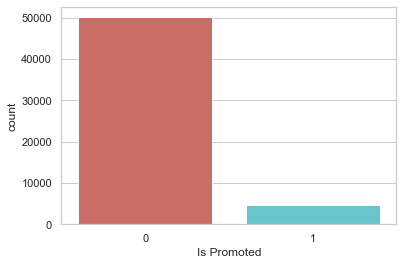

In [77]:
df_hr['is_promoted'].value_counts()

sns.countplot(x='is_promoted', data=df_hr, palette='hls')
plt.xlabel('Is Promoted')
plt.show()

In [78]:
# Express the total count of both classes of the target variable as percentages
count_notpromoted = len(df_hr[df_hr['is_promoted']==0])
count_promoted = len(df_hr[df_hr['is_promoted']==1])

pct_of_notpromoted = count_notpromoted/(count_notpromoted+count_promoted)
print("Percentage of non-promotees is", pct_of_notpromoted*100)

pct_of_promoted = count_promoted/(count_notpromoted+count_promoted)
print("Percentage of promotees is", pct_of_promoted*100)

Percentage of non-promotees is 91.48299518318494
Percentage of promotees is 8.517004816815064


Promotees account for about 8.52% of our dataset. And the ratio of promotees to non-promotees is approximately 9:91

### 1.2 Cleanse and Transform the data <a id='clean' />

#### 1.2.1 Check for null values

In [79]:
df_hr.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

#### 1.2.2 Cleanse the dataset by dropping all NaN values and unnecessary columns

In [80]:
df_hr = df_hr.dropna()
df_hr = df_hr.drop(columns=['employee_id','recruitment_channel'])
df_hr.head()

department     region         education gender  no_of_trainings  \
0  Sales & Marketing   region_7  Master's & above      f                1   
1         Operations  region_22        Bachelor's      m                1   
2  Sales & Marketing  region_19        Bachelor's      m                1   
3  Sales & Marketing  region_23        Bachelor's      m                2   
4         Technology  region_26        Bachelor's      m                1   

   age  previous_year_rating  length_of_service  KPIs_met >80%  awards_won?  \
0   35                   5.0                  8              1            0   
1   30                   5.0                  4              0            0   
2   34                   3.0                  7              0            0   
3   39                   1.0                 10              0            0   
4   45                   3.0                  2              0            0   

   avg_training_score  is_promoted  
0                  49            0  
1                  60            0  
2                  50            0  
3                  50            0  
4                  73            0

In [81]:
df_hr['is_promoted'].value_counts()

0    44428
1     4232
Name: is_promoted, dtype: int64

#### 1.2.3 Stratified sampling of dataset based on target variable

As mentioned earlier, an overwhelming majority (91%) of our samples constitute `is_promoted = 0`, hence we need to use random stratified sampling to ensure equal-sized samples of `is_promoted = 0` and `is_promoted = 1` for a balanced dataset.

In [82]:
# Obtain the promotees dataset
df_hr1=df_hr[df_hr['is_promoted']==1]
df_hr1.head()

department     region         education gender  no_of_trainings  \
11  Sales & Marketing   region_7        Bachelor's      f                1   
39  Sales & Marketing  region_28        Bachelor's      m                1   
60  Sales & Marketing   region_4  Master's & above      m                1   
69          Analytics  region_31        Bachelor's      m                1   
71         Technology  region_22  Master's & above      m                1   

    age  previous_year_rating  length_of_service  KPIs_met >80%  awards_won?  \
11   35                   5.0                  3              1            0   
39   33                   5.0                  6              1            0   
60   50                   4.0                 17              1            0   
69   30                   3.0                  7              1            0   
71   34                   5.0                  7              1            0   

    avg_training_score  is_promoted  
11                  50            1  
39                  51            1  
60                  47            1  
69                  84            1  
71                  78            1

In [83]:
# Calculate the size of the promotees dataset
len(df_hr1)

4232

In [84]:
# Obtain the non-promotees dataset
df_hr0=df_hr[df_hr['is_promoted']==0]
df_hr0.head()

department     region         education gender  no_of_trainings  \
0  Sales & Marketing   region_7  Master's & above      f                1   
1         Operations  region_22        Bachelor's      m                1   
2  Sales & Marketing  region_19        Bachelor's      m                1   
3  Sales & Marketing  region_23        Bachelor's      m                2   
4         Technology  region_26        Bachelor's      m                1   

   age  previous_year_rating  length_of_service  KPIs_met >80%  awards_won?  \
0   35                   5.0                  8              1            0   
1   30                   5.0                  4              0            0   
2   34                   3.0                  7              0            0   
3   39                   1.0                 10              0            0   
4   45                   3.0                  2              0            0   

   avg_training_score  is_promoted  
0                  49            0  
1                  60            0  
2                  50            0  
3                  50            0  
4                  73            0

In [85]:
# Extract a randomized sample of the non-promotees dataset that is the same size as the promotees dataset
df_hr0_sample = df_hr0.sample(n=len(df_hr1), random_state=2).copy()
df_hr0_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4232 entries, 823 to 51076
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            4232 non-null   object 
 1   region                4232 non-null   object 
 2   education             4232 non-null   object 
 3   gender                4232 non-null   object 
 4   no_of_trainings       4232 non-null   int64  
 5   age                   4232 non-null   int64  
 6   previous_year_rating  4232 non-null   float64
 7   length_of_service     4232 non-null   int64  
 8   KPIs_met >80%         4232 non-null   int64  
 9   awards_won?           4232 non-null   int64  
 10  avg_training_score    4232 non-null   int64  
 11  is_promoted           4232 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 429.8+ KB


In [86]:
# Concatenate the two datasets
df_hr=pd.concat([df_hr1,df_hr0_sample],axis=0)
df_hr['is_promoted'].value_counts()

1    4232
0    4232
Name: is_promoted, dtype: int64

In [87]:
# Get a statistical overview of the new stratified dataset
df_hr.describe()

no_of_trainings          age  previous_year_rating  length_of_service  \
count      8464.000000  8464.000000           8464.000000        8464.000000   
mean          1.229088    35.276465              3.629962           6.186555   
std           0.546848     7.211603              1.210701           4.045155   
min           1.000000    20.000000              1.000000           1.000000   
25%           1.000000    30.000000              3.000000           3.000000   
50%           1.000000    34.000000              4.000000           5.000000   
75%           1.000000    39.000000              5.000000           8.000000   
max           6.000000    60.000000              5.000000          34.000000   

       KPIs_met >80%  awards_won?  avg_training_score  is_promoted  
count    8464.000000  8464.000000         8464.000000   8464.00000  
mean        0.515714     0.065454           67.094518      0.50000  
std         0.499783     0.247339           14.379556      0.50003  
min         0.000000     0.000000           41.000000      0.00000  
25%         0.000000     0.000000           55.000000      0.00000  
50%         1.000000     0.000000           64.000000      0.50000  
75%         1.000000     0.000000           80.000000      1.00000  
max         1.000000     1.000000           99.000000      1.00000

### 1.3 Correlation Analysis <a id='correlate' />

#### 1.3.1 Comparison of numeric data against target variable

In [88]:
df_hr.groupby('is_promoted').mean()

no_of_trainings        age  previous_year_rating  \
is_promoted                                                     
0                   1.255198  35.510633              3.275520   
1                   1.202977  35.042297              3.984405   

             length_of_service  KPIs_met >80%  awards_won?  avg_training_score  
is_promoted                                                                     
0                     6.255907       0.333648     0.011815           62.866257  
1                     6.117202       0.697779     0.119093           71.322779

#### 1.3.2 Comparison of categorical data against target variable

Text(0.5, 0, 'Gender')

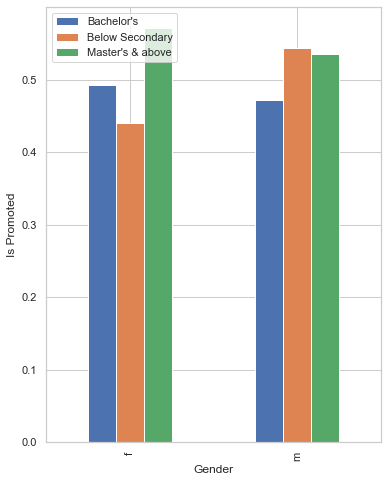

In [89]:
# Comparison of categorical data (Education and Gender) against target variable
df_hr.groupby(['education','gender']).is_promoted.mean().unstack(0).plot.bar(figsize=(6,8))
plt.legend(loc = 0)
plt.ylabel('Is Promoted')
plt.xlabel('Gender')

In [90]:
df_hr.groupby(['education','gender']).is_promoted.mean().unstack(1)

gender                   f         m
education                           
Bachelor's        0.492477  0.471797
Below Secondary   0.440000  0.543478
Master's & above  0.571266  0.534742

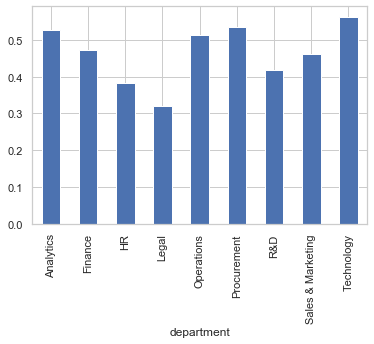

In [91]:
# Comparison of categorical data (Department) against target variable
df_hr.groupby('department').is_promoted.mean().plot.bar()

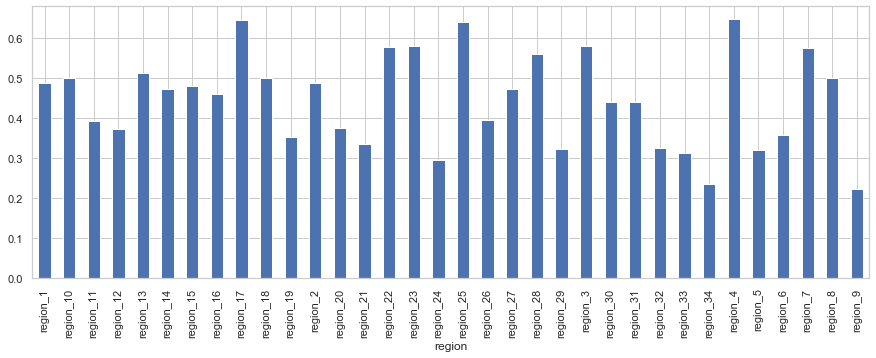

In [92]:
# Comparison of categorical data (Region) against target variable
df_hr.groupby('region').is_promoted.mean().plot.bar(figsize=(15,5))

#### 1.3.3 Encoding Categorical Data

Label encoding the categorical data allows the values to be correlated together with the numerical variables in the dataset. One-hot encoding was avoided as this would generate many additional columns to the dataset, generating unnecessary noise and make the dataset unwieldy to analyse.

In [93]:
df_hr[['department']]
print(np.unique(df_hr[['department']]))

['Analytics' 'Finance' 'HR' 'Legal' 'Operations' 'Procurement' 'R&D'
 'Sales & Marketing' 'Technology']


In [94]:
print(np.unique(df_hr[['region']]))

['region_1' 'region_10' 'region_11' 'region_12' 'region_13' 'region_14'
 'region_15' 'region_16' 'region_17' 'region_18' 'region_19' 'region_2'
 'region_20' 'region_21' 'region_22' 'region_23' 'region_24' 'region_25'
 'region_26' 'region_27' 'region_28' 'region_29' 'region_3' 'region_30'
 'region_31' 'region_32' 'region_33' 'region_34' 'region_4' 'region_5'
 'region_6' 'region_7' 'region_8' 'region_9']


In [95]:
print(np.unique(df_hr[['education']]))

["Bachelor's" 'Below Secondary' "Master's & above"]


In [96]:
# Encode Department
df_hr['department'] = df_hr['department'].map( {'Analytics': 0, 'Finance': 1, 'HR': 2, 'Legal': 3, 
                                                'Operations': 4, 'Procurement': 5, 'R&D': 6, 'Sales & Marketing': 7, 
                                                'Technology': 8} ).astype(int)

In [97]:
# Encode Region
df_hr['region'] = df_hr['region'].map( {'region_1': 1, 'region_10': 10, 'region_11': 11, 'region_12': 12,
                                        'region_13': 13, 'region_14': 14, 'region_15': 15, 'region_16': 16,
                                        'region_17': 17, 'region_18': 18, 'region_19': 19, 'region_2': 2,
                                        'region_20': 20, 'region_21': 21, 'region_22': 22, 'region_23': 23,
                                        'region_24': 24, 'region_25': 25, 'region_26': 26, 'region_27': 27,
                                        'region_28': 28, 'region_29': 29, 'region_3': 3, 'region_30': 30,
                                        'region_31': 31, 'region_32': 32, 'region_33': 33, 'region_34': 34, 
                                        'region_4': 4, 'region_5': 5, 'region_6': 6, 'region_7': 7, 
                                        'region_8': 8, 'region_9': 9} 
                                     ).astype(int)

In [98]:
# Encode Education
df_hr['education'] = df_hr['education'].map( {"Below Secondary": 0, "Bachelor's": 1, "Master's & above": 2} ).astype(int)

In [99]:
# Encode Gender
df_hr['gender'] = df_hr['gender'].map( {'f': 0, 'm': 1} ).astype(int)
df_hr.head()

department  region  education  gender  no_of_trainings  age  \
11           7       7          1       0                1   35   
39           7      28          1       1                1   33   
60           7       4          2       1                1   50   
69           0      31          1       1                1   30   
71           8      22          2       1                1   34   

    previous_year_rating  length_of_service  KPIs_met >80%  awards_won?  \
11                   5.0                  3              1            0   
39                   5.0                  6              1            0   
60                   4.0                 17              1            0   
69                   3.0                  7              1            0   
71                   5.0                  7              1            0   

    avg_training_score  is_promoted  
11                  50            1  
39                  51            1  
60                  47            1  
69                  84            1  
71                  78            1

In [100]:
# Min-Max normalization for Age, Length of Service and Avg Training Score columns
df_hr["age"] = (df_hr["age"] - df_hr["age"].min()) / (df_hr["age"].max()-df_hr["age"].min())
df_hr["length_of_service"] = (df_hr["length_of_service"] - df_hr["length_of_service"].min()) / (df_hr["length_of_service"].max()-df_hr["length_of_service"].min())
df_hr["avg_training_score"] = (df_hr["avg_training_score"] - df_hr["avg_training_score"].min()) / (df_hr["avg_training_score"].max()-df_hr["avg_training_score"].min())
df_hr.describe()

department       region    education       gender  no_of_trainings  \
count  8464.000000  8464.000000  8464.000000  8464.000000      8464.000000   
mean      4.946597    14.007207     1.307774     0.689272         1.229088   
std       2.501184     9.909555     0.479430     0.462819         0.546848   
min       0.000000     1.000000     0.000000     0.000000         1.000000   
25%       4.000000     4.000000     1.000000     0.000000         1.000000   
50%       5.000000    13.000000     1.000000     1.000000         1.000000   
75%       7.000000    22.000000     2.000000     1.000000         1.000000   
max       8.000000    34.000000     2.000000     1.000000         6.000000   

               age  previous_year_rating  length_of_service  KPIs_met >80%  \
count  8464.000000           8464.000000        8464.000000    8464.000000   
mean      0.381912              3.629962           0.157168       0.515714   
std       0.180290              1.210701           0.122580       0.499783   
min       0.000000              1.000000           0.000000       0.000000   
25%       0.250000              3.000000           0.060606       0.000000   
50%       0.350000              4.000000           0.121212       1.000000   
75%       0.475000              5.000000           0.212121       1.000000   
max       1.000000              5.000000           1.000000       1.000000   

       awards_won?  avg_training_score  is_promoted  
count  8464.000000         8464.000000   8464.00000  
mean      0.065454            0.449905      0.50000  
std       0.247339            0.247923      0.50003  
min       0.000000            0.000000      0.00000  
25%       0.000000            0.241379      0.00000  
50%       0.000000            0.396552      0.50000  
75%       0.000000            0.672414      1.00000  
max       1.000000            1.000000      1.00000

#### 1.3.4 Overview of Pearson Correlation of  numerical variables to the target variable (is_promoted)

In [101]:
df_hr.corr()

department    region  education    gender  \
department              1.000000 -0.086507   0.044748 -0.020053   
region                 -0.086507  1.000000  -0.102961  0.100838   
education               0.044748 -0.102961   1.000000 -0.022661   
gender                 -0.020053  0.100838  -0.022661  1.000000   
no_of_trainings        -0.049886  0.028369  -0.025588  0.083337   
age                     0.089537 -0.269485   0.379037 -0.001837   
previous_year_rating   -0.088938 -0.009705   0.022382 -0.025558   
length_of_service       0.062088 -0.181203   0.235061 -0.014034   
KPIs_met >80%          -0.034209  0.003425   0.014087 -0.036613   
awards_won?            -0.001034 -0.003037   0.017431  0.004277   
avg_training_score     -0.173449  0.038075   0.033059 -0.029853   
is_promoted             0.010109 -0.028604   0.061365 -0.024508   

                      no_of_trainings       age  previous_year_rating  \
department                  -0.049886  0.089537             -0.088938   
region                       0.028369 -0.269485             -0.009705   
education                   -0.025588  0.379037              0.022382   
gender                       0.083337 -0.001837             -0.025558   
no_of_trainings              1.000000 -0.081650             -0.047562   
age                         -0.081650  1.000000             -0.000556   
previous_year_rating        -0.047562 -0.000556              1.000000   
length_of_service           -0.056714  0.615346             -0.017413   
KPIs_met >80%               -0.027656 -0.031957              0.290423   
awards_won?                 -0.029628 -0.005178              0.065897   
avg_training_score           0.057668 -0.081421              0.128028   
is_promoted                 -0.047750 -0.032473              0.292775   

                      length_of_service  KPIs_met >80%  awards_won?  \
department                     0.062088      -0.034209    -0.001034   
region                        -0.181203       0.003425    -0.003037   
education                      0.235061       0.014087     0.017431   
gender                        -0.014034      -0.036613     0.004277   
no_of_trainings               -0.056714      -0.027656    -0.029628   
age                            0.615346      -0.031957    -0.005178   
previous_year_rating          -0.017413       0.290423     0.065897   
length_of_service              1.000000      -0.056185    -0.065941   
KPIs_met >80%                 -0.056185       1.000000     0.037561   
awards_won?                   -0.065941       0.037561     1.000000   
avg_training_score            -0.044748       0.022039     0.182082   
is_promoted                   -0.017146       0.364310     0.216877   

                      avg_training_score  is_promoted  
department                     -0.173449     0.010109  
region                          0.038075    -0.028604  
education                       0.033059     0.061365  
gender                         -0.029853    -0.024508  
no_of_trainings                 0.057668    -0.047750  
age                            -0.081421    -0.032473  
previous_year_rating            0.128028     0.292775  
length_of_service              -0.044748    -0.017146  
KPIs_met >80%                   0.022039     0.364310  
awards_won?                     0.182082     0.216877  
avg_training_score              1.000000     0.294064  
is_promoted                     0.294064     1.000000

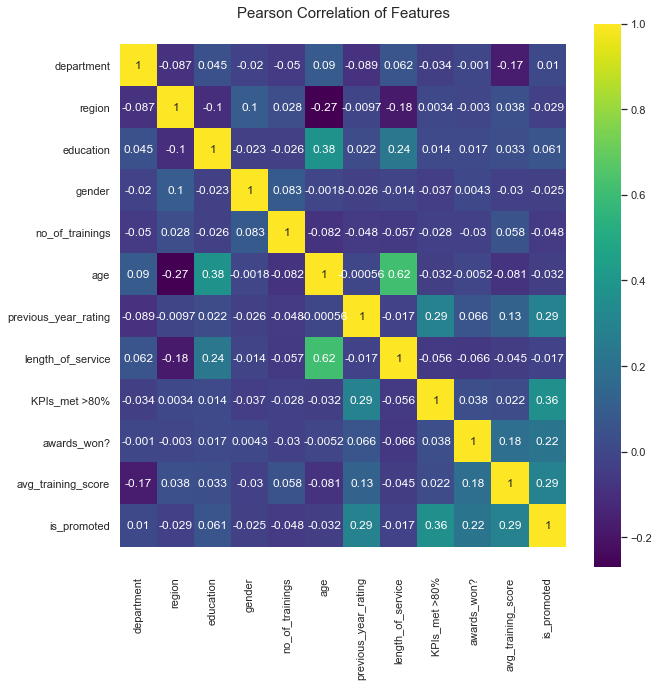

In [102]:
# A heatmap was generated to examine the correlation between any two features/variables
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(df_hr.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### 1.3.5 Scatter Matrices of variables

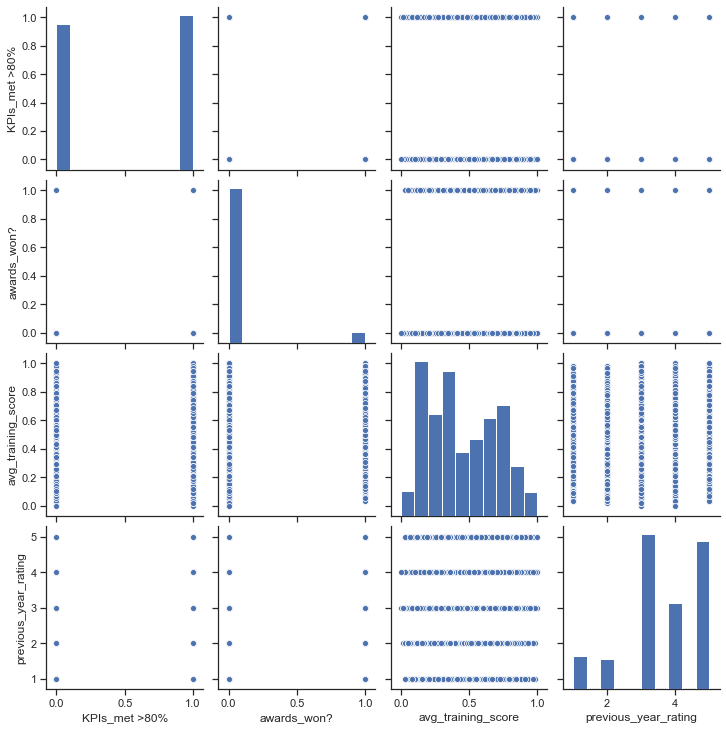

In [103]:
# Scatter Matrix 1
sns.set(style="ticks")
sns.pairplot(df_hr[['KPIs_met >80%', 'awards_won?', 'avg_training_score','previous_year_rating']])

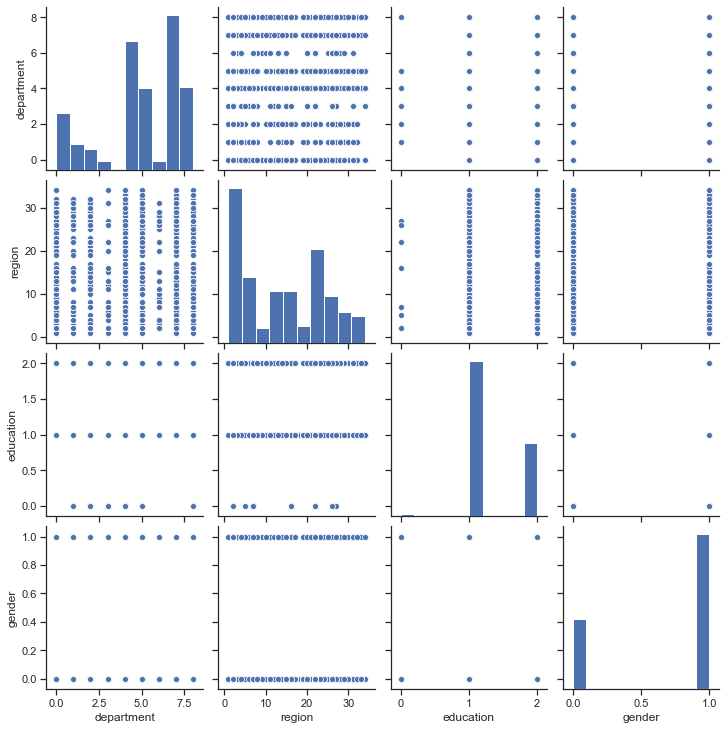

In [104]:
# Scatter Matrix 2
sns.set(style="ticks")
sns.pairplot(df_hr[['department', 'region', 'education', 'gender']])

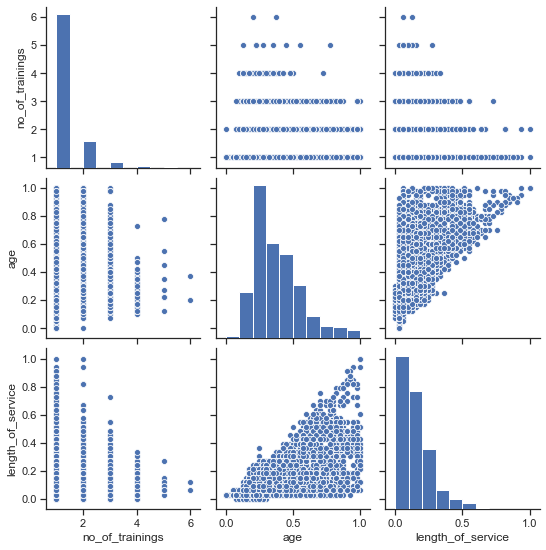

In [105]:
# Scatter Matrix 3
sns.set(style="ticks")
sns.pairplot(df_hr[['no_of_trainings', 'age', 'length_of_service']])

#### 1.3.6 Observations

1. Promoted employees had a higher average of a) previous year's rating, b) meeting >80% of their KPIs, c) awards won, and d) training scores.
2. Interestingly, the average age, number of trainings received, and length of service of promotees were lower than those of non-promotees.
3. Promotees were quite evenly split between both genders and employees with a Master's Degree & Above formed the largest subgroup for both.
4. On average, the highest number of promotees came from the Technology department, followed by Analytics and Procurement.
5. On average, most promotees came from Region 4, Region 17 and Region 25.
6. The top three variables that show a positive correlation with the target variable are - KPIs>80%, awards won and average training scores

### 1.4 Export the data <a id='export' />

In [106]:
df_hr.to_csv('hr_data_new.csv', index=False)

## 2. Airbnb Singapore

1. [Load and Explore the Data](#load2)
2. [Cleanse and Transform the Data](#clean2)
3. [Correlation Analysis](#correlate2)
4. [Export the Data](#export2)

### 2.1 Load and Explore the data <a id='load2' />

#### 2.1.1 Load Dataframe

In [107]:
df_airbnb = pd.read_csv('listings.csv', header=0)
print('dataframes loaded!')

dataframes loaded!


In [108]:
# Check dataframe import
df_airbnb.head()

id                                 name  host_id  host_name  \
0  49091    COZICOMFORT LONG TERM STAY ROOM 2   266763  Francesca   
1  50646      Pleasant Room along Bukit Timah   227796    Sujatha   
2  56334                          COZICOMFORT   266763  Francesca   
3  71609  Ensuite Room (Room 1 & 2) near EXPO   367042    Belinda   
4  71896      B&B  Room 1 near Airport & EXPO   367042    Belinda   

  neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0             180                  1  2013-10-21               0.01   
1              90                 18  2014-12-26               0.28   
2               6                 20  2015-10-01               0.20   
3               1                 14  2019-08-11               0.15   
4               1                 22  2019-07-28               0.22   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1               365  
2                               2               365  
3                               9               353  
4                               9               355

In [109]:
df_airbnb.info()
print('The df_hr shape is', df_airbnb.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

### 2.2 Cleanse and Transform the data <a id='clean2' />

#### 2.2.1 Check for null values

In [110]:
df_airbnb.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

As the number of proportion of null values in this dataset is significant (~34.9%), dropping null values may adversely affect the shape of our dataset and hence, our predictive model. 

Instead, we will use the fillna function to substitute the reviews_per_month null records with the average of the column as this could hold implicit information about how popular a rental is with Airbnb users.

#### 2.2.2 Cleanse the dataset by using fillna and dropping unnecessary columns

In [111]:
# Fillna for 'reviews_per_month' with column mean
avg_reviews = df_airbnb['reviews_per_month'].mean(axis=0)
df_airbnb['reviews_per_month'].replace(np.nan, avg_reviews, inplace=True)

# Drop unnecessary columns
df_airbnb = df_airbnb.drop(columns=['id','name','host_id','host_name','last_review','calculated_host_listings_count'])
df_airbnb.head(10)

neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   
5         East Region      Tampines   1.34702  103.96103  Private room    104   
6         East Region      Tampines   1.34348  103.96337  Private room    208   
7         East Region         Bedok   1.32304  103.91363  Private room     50   
8         East Region         Bedok   1.32458  103.91163  Private room     54   
9         East Region         Bedok   1.32461  103.91191  Private room     42   

   minimum_nights  number_of_reviews  reviews_per_month  availability_365  
0             180                  1               0.01               365  
1              90                 18               0.28               365  
2               6                 20               0.20               365  
3               1                 14               0.15               353  
4               1                 22               0.22               355  
5               1                 39               0.38               346  
6               1                 25               0.25               172  
7              90                174               1.88                59  
8              90                198               2.08               133  
9              90                236               2.53               147

In [112]:
# Double-check for null values
df_airbnb.isnull().sum()

neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
availability_365       0
dtype: int64

In [113]:
df_airbnb.describe()

latitude    longitude         price  minimum_nights  \
count  7907.000000  7907.000000   7907.000000     7907.000000   
mean      1.314192   103.848787    169.332996       17.510054   
std       0.030577     0.043675    340.187599       42.094616   
min       1.243870   103.646560      0.000000        1.000000   
25%       1.295795   103.835825     65.000000        1.000000   
50%       1.311030   103.849410    124.000000        3.000000   
75%       1.322110   103.872535    199.000000       10.000000   
max       1.454590   103.973420  10000.000000     1000.000000   

       number_of_reviews  reviews_per_month  availability_365  
count        7907.000000        7907.000000       7907.000000  
mean           12.807386           1.043669        208.726318  
std            29.707746           1.037604        146.120034  
min             0.000000           0.010000          0.000000  
25%             0.000000           0.330000         54.000000  
50%             2.000000           1.043669        260.000000  
75%            10.000000           1.043669        355.000000  
max           323.000000          13.000000        365.000000

#### 2.2.3 Examine dataset for outliers

We can observe from the above summary table that the columns Price, Minimum Nights, No of Reviews and Reviews per Month are highly likely to contain outliers given the stark difference between their max and mean and upper quartile values.

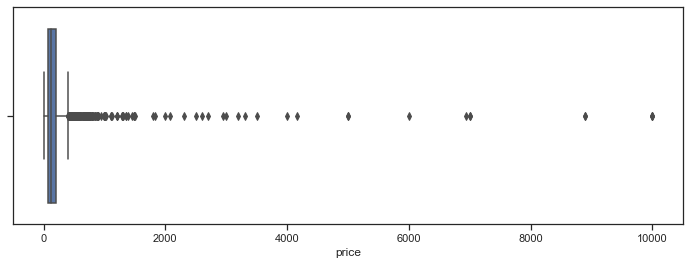

In [114]:
# Use a box plot to check for outliers in the target variable (price)
plt.figure(figsize=(12,4))
sns.boxplot(df_airbnb['price'])
plt.show()

This box plot confirms the presence of numerous outliers in the price column. This can also be seen when referencing the data description summary table above, which indicates the average of the price variable is 169 and its IQR range is between 65 to 199. 

Two possible areas that may affect price are room types and neighbourhood groups. 

In [115]:
df_airbnb.groupby(['neighbourhood_group','room_type']).price.mean().unstack(0)

neighbourhood_group  Central Region  East Region  North Region  \
room_type                                                        
Entire home/apt          224.581862   209.358779    188.433962   
Private room             114.380117   117.234973     81.992958   
Shared room               59.198276   187.090909    107.666667   

neighbourhood_group  North-East Region  West Region  
room_type                                            
Entire home/apt             191.671875   334.178082  
Private room                 79.878676   117.825397  
Shared room                  55.000000   106.125000

As can be seen from this groupby table, Entire Home rentals draw the highest prices across all regions, while prices vary shift across Private and Shared Rooms across different neighbourhood groups. 

Correlating room type and neighbourhood group variables with price will indicate whether these are important variables to include in our predictive model. It is also worth considering a focus on a particular room type and/or neighbourhood group when building the predictive model for a more customized and effective predictive model.

Text(0.5, 0, 'Room Type')

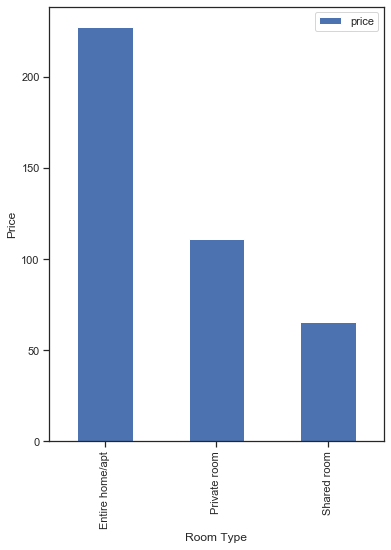

In [116]:
# Comparison of categorical data (Room Type) against target variable
df_airbnb.groupby(['room_type']).price.mean().plot.bar(figsize=(6,8))
plt.legend(loc = 0)
plt.ylabel('Price')
plt.xlabel('Room Type')

We can observe from this bar chart that Entire Home rentals hold the highest average price - about twice that of a private room and four times that of a shared room

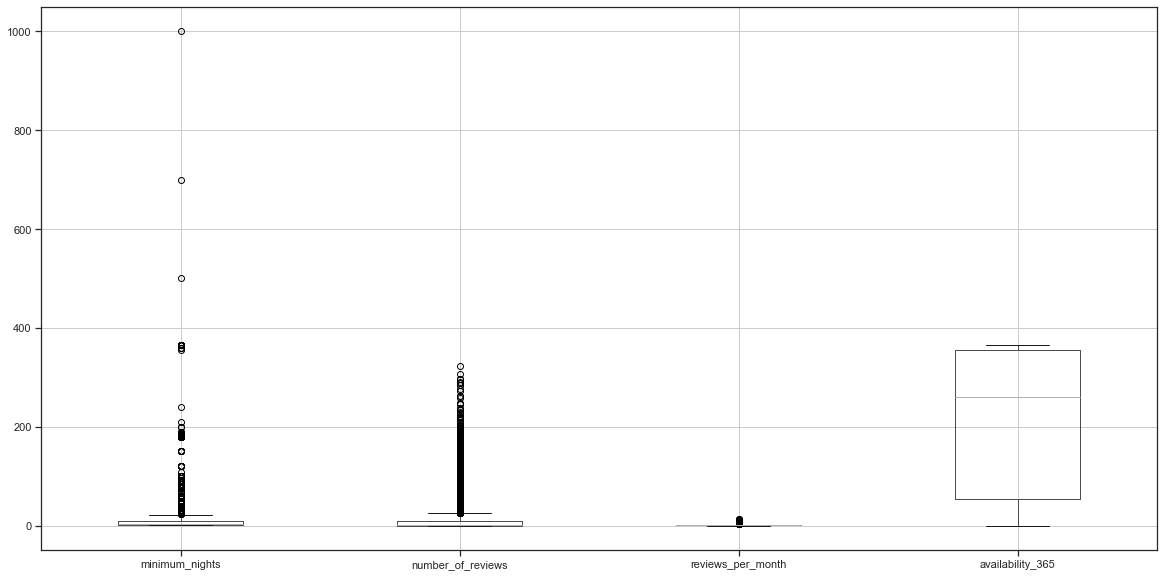

In [117]:
plt.figure(figsize = (20, 10))
df_airbnb.loc[:, ['minimum_nights','number_of_reviews','reviews_per_month','availability_365']].boxplot()
plt.show()

These boxplots indicate that there are also outliers present, as mentioned earlier, in the minimum_nights, number_of_reviews and reviews_per_month columns

#### 2.2.4 Remove outliers before analysis

It is necessary for us to remove the outliers before we conduct our correlational analysis and also to avoid adversely impacting our predictive model's accuracy

In [118]:
# Obtain the IQR range for each column in the dataset
Q1 = df_airbnb.quantile(0.25)
Q3 = df_airbnb.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

latitude               0.026315
longitude              0.036710
price                134.000000
minimum_nights         9.000000
number_of_reviews     10.000000
reviews_per_month      0.713669
availability_365     301.000000
dtype: float64


In [119]:
# Remove the outliers and assign the new values to the df_airbnb dataframe
df_airbnb = df_airbnb[~((df_airbnb < (Q1 - 1.5 * IQR)) |(df_airbnb > (Q3 + 1.5 * IQR))).any(axis=1)]
df_airbnb.describe()

latitude    longitude        price  minimum_nights  \
count  4131.000000  4131.000000  4131.000000      4131.00000   
mean      1.306059   103.855470   147.312031         4.57008   
std       0.016562     0.026769    87.281739         4.95262   
min       1.256390   103.781130     0.000000         1.00000   
25%       1.294670   103.840730    79.000000         1.00000   
50%       1.309550   103.851960   132.000000         3.00000   
75%       1.315560   103.871700   200.000000         6.00000   
max       1.361580   103.926440   400.000000        22.00000   

       number_of_reviews  reviews_per_month  availability_365  
count        4131.000000        4131.000000       4131.000000  
mean            3.699104           0.718112        206.270879  
std             5.647622           0.459606        151.437176  
min             0.000000           0.020000          0.000000  
25%             0.000000           0.250000         35.000000  
50%             1.000000           0.940000        264.000000  
75%             5.000000           1.043669        356.000000  
max            25.000000           2.090000        365.000000

We have reduced our records by approximately 3,700 rows or ~47% of our dataset. Although this is a significant reduction in records, our primary purpose here is to accurately explore the correlation of all variables. We can focus on subsets of the data or try and obtain more records when training our predictive model.

### 2.3 Correlation Analysis <a id='correlate2' />

Once again, label encoding was used on the categorical data to allow their correlation with numerical variables in the dataset.

#### 2.3.1 Encoding Categorical Data

In [120]:
print(np.unique(df_airbnb[['room_type']]))

['Entire home/apt' 'Private room' 'Shared room']


In [121]:
print(np.unique(df_airbnb[['neighbourhood']]))

['Bedok' 'Bishan' 'Bukit Merah' 'Bukit Timah' 'Central Water Catchment'
 'Downtown Core' 'Geylang' 'Hougang' 'Kallang' 'Marine Parade' 'Museum'
 'Newton' 'Novena' 'Orchard' 'Outram' 'Queenstown' 'River Valley' 'Rochor'
 'Serangoon' 'Singapore River' 'Southern Islands' 'Tanglin' 'Toa Payoh']


In [122]:
print(np.unique(df_airbnb[['neighbourhood_group']]))

['Central Region' 'East Region' 'North Region' 'North-East Region']


In [123]:
# Encode Room Types
df_airbnb['room_type'] = df_airbnb['room_type'].map({'Entire home/apt': 1, 'Private room': 2, 
                                                    'Shared room': 3
                                                    } ).astype(int)

In [124]:
df_airbnb.groupby('room_type').count()

neighbourhood_group  neighbourhood  latitude  longitude  price  \
room_type                                                                   
1                         2315           2315      2315       2315   2315   
2                         1543           1543      1543       1543   1543   
3                          273            273       273        273    273   

           minimum_nights  number_of_reviews  reviews_per_month  \
room_type                                                         
1                    2315               2315               2315   
2                    1543               1543               1543   
3                     273                273                273   

           availability_365  
room_type                    
1                      2315  
2                      1543  
3                       273

In [125]:
# Map view of the AirBnb listings in our new dataset
# Set location to the latitude and longitude of Singapore
import folium
airbnb_sg = folium.Map(location=[1.290270, 103.851959], zoom_start=12)
roomtypes = 4

# Set colour scheme  for the Room Type
x = np.arange(roomtypes)
ys = [i + x + (i*x)**2 for i in range(roomtypes)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Set colour markers and labels
markers_colors = []
for lat, lon, poi, rmtype in zip(df_airbnb['latitude'], df_airbnb['longitude'], df_airbnb['neighbourhood'], df_airbnb['room_type']):
    label = folium.Popup(str(poi) + ' Room Type - ' + str(rmtype))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(rmtype)-1],
        fill=True,
        fill_color=rainbow[int(rmtype)-1],
        fill_opacity=0.7).add_to(airbnb_sg)

# Load map    
airbnb_sg

We can see from the above map that the majority of our reduced dataset (after removing outliers) consist of Entire Homes (Type 1) and Private Rooms (Type 2), while there are significantly fewer listings for Shared Rooms (Type 3).

The listings also appear to be concentrated in the Central and East neighbourhood groups of Singapore

In [126]:
# Encode Neighbourhoods
df_airbnb['neighbourhood'] = df_airbnb['neighbourhood'].map({'Ang Mo Kio': 1, 'Bedok': 2, 'Bishan': 3, 'Bukit Batok': 4,
                                                             'Bukit Merah': 5, 'Bukit Panjang': 6, 'Bukit Timah': 7, 'Central Water Catchment': 8,
                                                             'Choa Chu Kang': 9, 'Clementi': 10, 'Downtown Core': 11, 'Geylang': 12,
                                                             'Hougang': 13, 'Jurong East': 14, 'Jurong West': 15, 'Kallang': 16,
                                                             'Lim Chu Kang': 17, 'Mandai': 18, 'Marina South': 19, 'Marine Parade': 20,
                                                             'Museum': 21, 'Newton': 22, 'Novena': 23, 'Orchard': 24, 'Outram': 25, 'Pasir Ris':26,
                                                             'Punggol': 27, 'Queenstown': 28, 'River Valley': 29, 'Rochor': 30,
                                                             'Sembawang': 31, 'Sengkang': 32, 'Serangoon': 33, 'Singapore River': 34,
                                                             'Southern Islands': 35, 'Sungei Kadut': 36, 'Tampines': 37, 'Tanglin': 38,
                                                             'Toa Payoh': 39, 'Tuas': 40, 'Western Water Catchment': 41, 'Woodlands': 42,
                                                             'Yishun':43
                                                             } ).astype(int)

In [127]:
# Encode Neighbourhood Groups
df_airbnb['neighbourhood_group'] = df_airbnb['neighbourhood_group'].map({'Central Region': 1,'East Region': 2, 
                                                                         'North Region': 3, 'North-East Region': 4
                                                                        } ).astype(int)

#### 2.3.2 Pearson Correlation of variables to the target variable (price)

In [128]:
# Drop latitude and longitude columns to reduce data noise
df_airbnb = df_airbnb.drop(columns=['latitude','longitude'])

In [129]:
df_airbnb.corr()

neighbourhood_group  neighbourhood  room_type     price  \
neighbourhood_group             1.000000      -0.181889   0.104887 -0.103666   
neighbourhood                  -0.181889       1.000000   0.049046  0.030465   
room_type                       0.104887       0.049046   1.000000 -0.580878   
price                          -0.103666       0.030465  -0.580878  1.000000   
minimum_nights                 -0.033276      -0.012532  -0.145652 -0.042042   
number_of_reviews              -0.012134       0.042027   0.030205 -0.075876   
reviews_per_month              -0.023904       0.000572  -0.070150  0.098500   
availability_365               -0.087677       0.023501   0.040044  0.139130   

                     minimum_nights  number_of_reviews  reviews_per_month  \
neighbourhood_group       -0.033276          -0.012134          -0.023904   
neighbourhood             -0.012532           0.042027           0.000572   
room_type                 -0.145652           0.030205          -0.070150   
price                     -0.042042          -0.075876           0.098500   
minimum_nights             1.000000          -0.130225          -0.054647   
number_of_reviews         -0.130225           1.000000          -0.031381   
reviews_per_month         -0.054647          -0.031381           1.000000   
availability_365           0.216964          -0.032861           0.010600   

                     availability_365  
neighbourhood_group         -0.087677  
neighbourhood                0.023501  
room_type                    0.040044  
price                        0.139130  
minimum_nights               0.216964  
number_of_reviews           -0.032861  
reviews_per_month            0.010600  
availability_365             1.000000

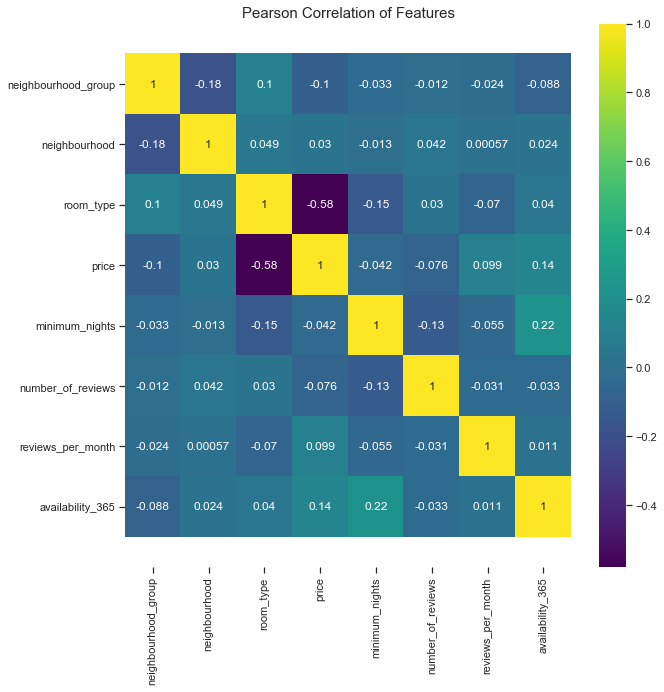

In [130]:
# The Heatmap allows the correlation between any two features/variables in the dataset
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(df_airbnb.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### 2.3.3 Scatter Matrix of variables

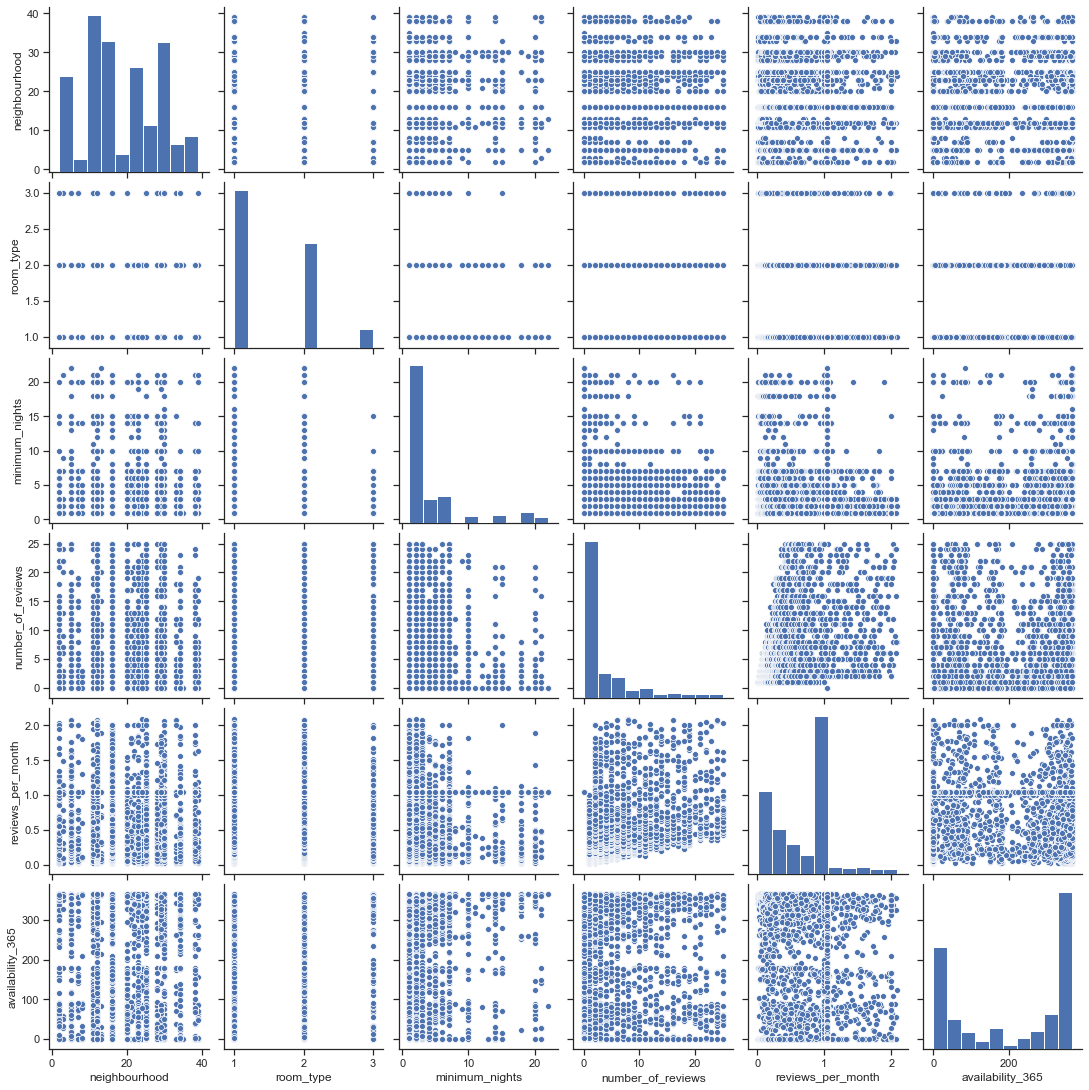

In [131]:
# Scatter Matrix
sns.set(style="ticks")
sns.pairplot(df_airbnb[['neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']])

#### 2.3.4 Histogram analysis

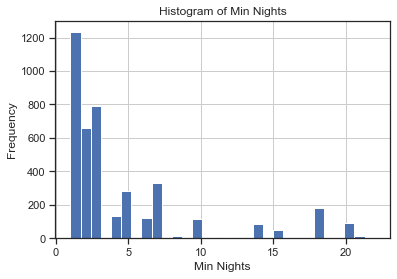

In [132]:
# Minimum number of nights
plt.hist(df_airbnb['minimum_nights'],bins = 30)
plt.ylim(0, 1300)
plt.xlabel('Min Nights')
plt.ylabel('Frequency') 
plt.title('Histogram of Min Nights')
plt.grid(True)

plt.show()

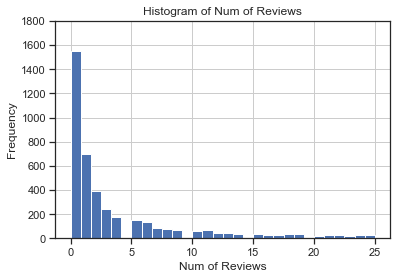

In [133]:
# Num of Reviews
plt.hist(df_airbnb['number_of_reviews'],bins = 30)
plt.ylim(0, 1800)
plt.xlabel('Num of Reviews')
plt.ylabel('Frequency') 
plt.title('Histogram of Num of Reviews')
plt.grid(True)

plt.show()

#### 2.3.5 Scatter plot (Regression plot) analysis of variables

The heatmap indicates a slight correlation between the Reviews per Month and Availability 365 variables with the target variable. The use of a scatter plot here examines the presence of any linear relationship between the variables.

Text(0, 0.5, 'Price')

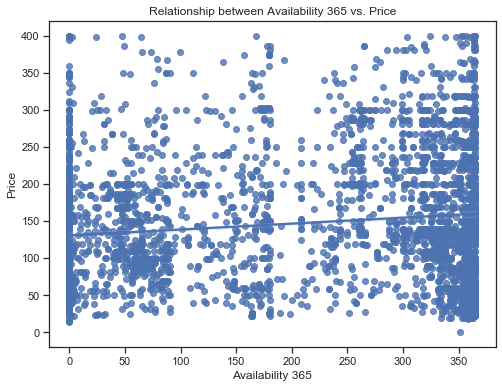

In [134]:
# Availability 365 vs Price
plt.figure(figsize=(8,6))
sns.regplot(x='availability_365', y='price', data=df_airbnb)

plt.title('Relationship between Availability 365 vs. Price')
plt.xlabel('Availability 365')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

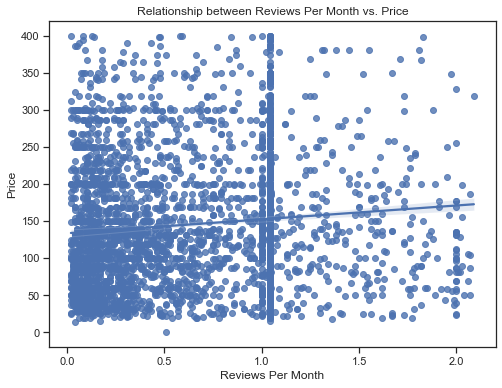

In [135]:
# Reviews Per Month vs Price
plt.figure(figsize=(8,6))
sns.regplot(x='reviews_per_month', y='price', data=df_airbnb)

plt.title('Relationship between Reviews Per Month vs. Price')
plt.xlabel('Reviews Per Month')
plt.ylabel('Price')

#### 2.3.6 Observations

1. Room types are strongly correlated with the target variable, while neighbourhood group and availability 365 show a slight correlation.
2. Room type average prices reveal a distinct differences between each, with Entire Home rentals holding the highest price - about twice that of a private room and four times that of a shared room.
3. Pricing of room types vary according to the different neighbourhood groups. This could give an indication as to the kind of clientele choosing to rent certain locations - expatriates renting homes in the Central region, etc.
3. A large proportion of our dataset listings posted < 5 minimum night stay threshold and hold < 5 guest reviews.
4. Although Availability 365 counts among the top three variables with a correlation to the target variable, a scatter plot does not indicate any kind of linear relationship.
5. Review ratings of rental listing is an important info gap here. This could prove to have a strong correlation to price and help in the accuracy of our model.

### 2.4 Export the data <a id='export2' />

In [136]:
df_airbnb.to_csv('listings_new.csv', index=False)